<a id="top">

# Payment Reconciliation - Validating CLA data against RVMS Budget Summary Data

### PURPOSE:

The purpose of this Python script is to create the necessary backup data needed to verify that CLA data matches the data in RVMS for the chosen CLA Claim Month (YYYYMM).

Currently, each Normal Warranty reserve analyst pulls various pieces of data separately (3 queries: QMF CLA claims, seatbelt claims, and all other claims) for just their own plants and merge or matches them together using Excel's **```index/match```** function.  There are some significant manual processes involved which can inadvertently introduce errors and a local "short version" of GraphCats descriptions are maintained outside of RVMS, which is another source for potential errors.  It is also a potential unnecessary maintenance step as  "long version" of GraphCats descriptions could be used in place of the short version GraphCats which are in RVMS.

The general process that this Python script performs is obtaining the necessary data for all plants (and therefore for all Reserve analysts) and merge the data sets in a more efficient manner that essentially replaces or removes the need for manual and tedious Excel **```index/match```** functions.  This should also have the added benefit of preventing inadvertent errors.  Below is the high level data processing steps that this script performs:

[1.](#CLA_DB2) Get CLA claims for the requested claim month from DB2 server (DSSOGW01).  Save data set as Excel file.<br>
[2.](#CLA_SQL_SERVER) Get CLA claims for the requested claim month from SQL Server (MMP-SQLP-WARRANTY).  Save data set as Excel file.<br>
[3.](#Validate_CLA_DB2_SQL_Server) Confirm or validate that claim counts from DB2 and SQL Server match and also confirm both native and USD warranty total charge amounts are the same between the 2 database servers.  If there are discrepancies, the script will error out and further processing will be halted.<br>
[4.](#RVMS_GraphCat_MTC) From RVMS server, obtain the GraphCat Descriptions and their associated MTC Model, Type, and Option.  Save data set as Excel file.<br>
[5.](#unique_graphcats) From RVMS server, obtain list of unique GraphCat IDs and their respective descriptions.<br>
[6.](#CLA_With_GraphCat_MTC) Merge CLA DB2 claims from **```step 1```** with the GraphCat to MTC Model, Type, and Option table from **```step 4```**.  Save data set as Excel file.<br>
[7.](#CLA_Merge_Check) Confirm or validate that the claim count from the merged CLA DB2 claims from **```step 6```** matches the claim count from the original CLA DB2 claim set in **```step 1```**.  Also confirm that both the native currency and USD warranty total charge amounts are also the same between the 2 data sets.<br>
[8.](#RVMS_Budget_Summary) From RVMS server, obtain the "Budget Summary" output which contains the GraphCat descriptions and their "Actual_Cost" amounts.<br>
[9.](#Add_Features_RVMS_Budget_Summary) Add ```ModelYear```, ```Factory```, and ```ModelName``` columns to the RVMS Budget Summary data set from **```step 8```**.  Save data set as Excel file.<br>
[10.](#Summarize_CLA_Native_Currency) Summarize the CLA DB2 claims with GraphCat descriptions (from **```step 6```**) by summing up the native currency cost of the total warranty charge amount by GraphCat ID.<br>
[11.](#CLA_GraphCat_Desc) Merge the data set from **```step 10```** with the unique list of GraphCat descriptions (from **```step 5```**) by GraphCat ID so the resulting data set now has GraphCat descriptions.  Save data set as Excel file.<br>
[12.](#CLA_Features) Add ```ModelYear```, ```Factory```, and ```ModelName``` columns to the summarized CLA data set from **```step 11```**.<br>
[13.](#CLA_to_RVMS_Total_Charge_Merge) Merge data set from **```step 12```** with the RVMS Budget Summary data from **```step 8```**.  Save data set as Excel file.

After the Python script logic and process has been fully validated, the **end goal** is to migrate this into a QlikView application to do these data extraction and integration steps that **ALL** reserve analysts can use and benefit from.  However, not sure if QlikView has a ability to send alerts or do data validation checks.

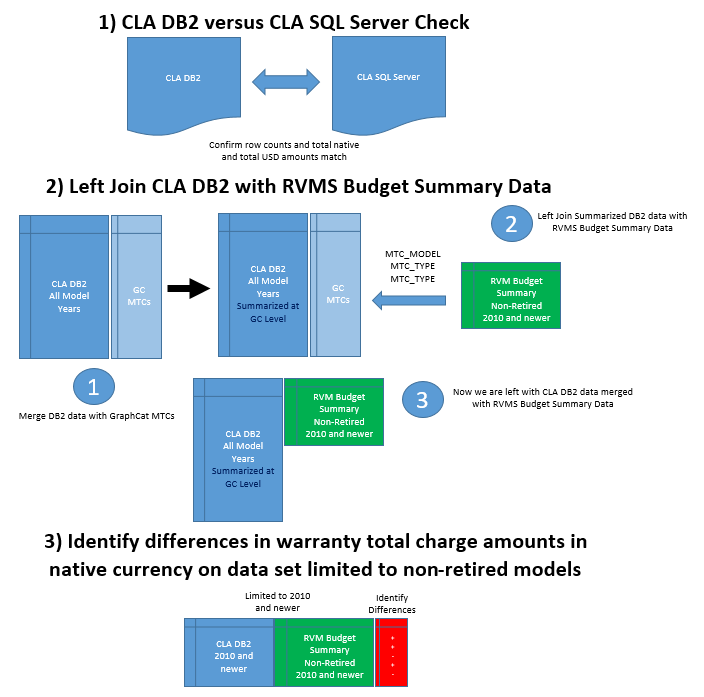

In [87]:
from IPython.display import Image 
Image(filename='images/CLA_vs_RVMS_Check_Process.png')

In [1]:
import great_expectations as ge
import time
from pathlib import Path
from win10toast import ToastNotifier
import os
import pyodbc  # used for connecting to ODBC data sources
import pandas as pd  # data analysis library
pd.options.display.max_rows=1000
pd.options.display.max_columns=100

### Mainframe DB2 Database credentials:

In [2]:
userid_db2 = os.environ['windowsuser']
pw_db2     = os.environ['mainframepwd']
dsn_cla_db2 = 'DSSOGW01'

### SQL Server Database credentials:

In [3]:
userid_sqlserver = os.environ['windowsuser']
pw_sqlserver     = os.environ['windowspwd']
dsn_cla_sqlserver = 'MMP-SQLP-WARRANTY'

### RVMS Database Credentials

In [4]:
userid_rvms = os.environ['windowsuser']
pw_rvms     = os.environ['windowspwd']
dsn_rvms = 'HDC-SQLP-RVMS'

### Enter CLA Claim Month:

In [ ]:
CLA_MONTH = input("Enter CLA Claim Month ('YYYYMM'): ")

In [5]:
parameters = []
parameters.append(int(CLA_MONTH))
start_time = time.time()

Enter CLA Claim Month ('YYYYMM'): 201902


### Define where support data will be saved using the CLA claim month as part of the folder location:

In [6]:
base_dir = "//207.130.185.67/aqgbudget2/Cost/Reserve Adjustments/Reports/Normal Reserve Balance Verification/CLA_vs_RVMS_Check"
p = Path(base_dir)
save_dir = p / CLA_MONTH
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

<a id="CLA_DB2">

### Execute CLA claims query against DB2:

**NOTE:** This query needs to be modified once a year to add a retired model year.

[[back to top](#top)]

In [7]:
%%time

cnxn_string = 'DSN=' + dsn_cla_db2 + ';UID=' + userid_db2 + ';PWD=' + pw_db2

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
WITH WRSAL1 AS (
SELECT
    VIN_MANU_CODE,
    VIN_CAR_TYPE,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    VIN_CHECK_NO,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_SERIAL_NO,
    VEHICLE_DESTN_CODE,
    RTRIM(MTC_MODEL) AS MTC_MODEL,
    RTRIM(MTC_TYPE) AS MTC_TYPE,
    RTRIM(MTC_OPTION) AS MTC_OPTION,
    PROC_DATE_AF_OFF

FROM
    WAR.WRSAL1 AS WRSAL1

WHERE
    VIN_FACTORY IN('A','L','H','G','M','B','E','Y')

)

SELECT
    WAR_CLAIM_DATE,
    WAR_DEFECT_CODE,
    WAR_ORIG_DISTR_CDE,
    WAR_RESP_DISTR_CDE,
    CAMPAIGN_CODE,
    WAR_INVOICE_NO,
    GENERAL_LEDGR_DATE,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    VEHICLE_DESTN_CODE,
    MTC_MODEL,
    MTC_TYPE,
    MTC_OPTION,
    WAR_EXCH_RATE_AMT,
    CLAIM_TYPE,
    SUM(WAR_TOTAL_CHG_AMT_USD) AS WAR_TOTAL_CHG_AMT_USD,
    SUM(WAR_TOTAL_CHG_AMT_NATIVE) AS WAR_TOTAL_CHG_AMT_NATIVE

FROM (

SELECT
    WRCLA1.WAR_CLAIM_DATE,
    WRCLA1.WAR_DEFECT_CODE,
    WRCLA1.WAR_ORIG_DISTR_CDE,
    WRCLA1.WAR_RESP_DISTR_CDE,
    WRCLA1.CAMPAIGN_CODE,
    WRCLA1.WAR_INVOICE_NO,
    WRCLA1.GENERAL_LEDGR_DATE,
    WRCLA1.VIN_MODEL_YR,
    WRCLA1.VIN_FACTORY,
    WRCLA1.VIN_MODEL_TYPE,
    WRCLA1.VIN_TRANS_TYPE,
    WRCLA1.VIN_NO_DOORS,
    WRCLA1.VIN_GRADE,
    WRCLA1.VEHICLE_DESTN_CODE,
    RTRIM(WRSAL1.MTC_MODEL) AS MTC_MODEL,
    RTRIM(WRSAL1.MTC_TYPE) AS MTC_TYPE,
    RTRIM(WRSAL1.MTC_OPTION) AS MTC_OPTION,
    WRSAL1.PROC_DATE_AF_OFF AS AFOFFDT,
    WRCLA1.WAR_EXCH_RATE_AMT,
    /* Use of DECIMAL() function needed to avoid arithmetic overflow error */
    WRCLA1.WAR_TOTAL_CHG_AMT * DECIMAL(WRCLA1.WAR_EXCH_RATE_AMT,11,5) AS WAR_TOTAL_CHG_AMT_USD,
    WRCLA1.WAR_TOTAL_CHG_AMT AS WAR_TOTAL_CHG_AMT_NATIVE,

    CASE
    WHEN
    WRCLA1.VIN_MODEL_YR IN('W','X','Y','1','2','3','4','5','6')
    AND (WRCLA1.PART_NO LIKE '04813%'
        OR WRCLA1.PART_NO LIKE '04816%'
        OR WRCLA1.PART_NO LIKE '81455%'
        OR WRCLA1.PART_NO LIKE '81855%'
    ) THEN 'CHERRY SEATBELT CLAIM'
    WHEN
    
    /** These are your "retired" model years, so every Ki, someone needs to add a new retired model year **/
    WRCLA1.VIN_MODEL_YR IN('K','L','M','N','P','R','S','T','V','W','X','Y','1','2','3','4','5','6','7','8','9')
    /** Model Year Code is being recycled, so need to prevent getting unintended model years **/
    AND WRSAL1.PROC_DATE_AF_OFF <= '2016-12-31'
    AND (WRCLA1.PART_NO NOT LIKE '04813%'
        OR WRCLA1.PART_NO NOT LIKE '04816%'
        OR WRCLA1.PART_NO NOT LIKE '81455%'
        OR WRCLA1.PART_NO NOT LIKE '81855%'
    ) THEN 'NON-CHERRY SEATBELT CLAIM'
    ELSE 'OTHER' END AS CLAIM_TYPE


FROM
    WAR.WRCLA1 AS WRCLA1

    LEFT JOIN WRSAL1 AS WRSAL1 ON
        WRCLA1.VIN_MANU_CODE = WRSAL1.VIN_MANU_CODE
        AND WRCLA1.VIN_CAR_TYPE = WRSAL1.VIN_CAR_TYPE
        AND WRCLA1.VIN_MODEL_TYPE = WRSAL1.VIN_MODEL_TYPE
        AND WRCLA1.VIN_TRANS_TYPE = WRSAL1.VIN_TRANS_TYPE
        AND WRCLA1.VIN_NO_DOORS = WRSAL1.VIN_NO_DOORS
        AND WRCLA1.VIN_GRADE = WRSAL1.VIN_GRADE
        AND WRCLA1.VIN_CHECK_NO = WRSAL1.VIN_CHECK_NO
        AND WRCLA1.VIN_MODEL_YR = WRSAL1.VIN_MODEL_YR
        AND WRCLA1.VIN_FACTORY = WRSAL1.VIN_FACTORY
        AND WRCLA1.VIN_SERIAL_NO = WRSAL1.VIN_SERIAL_NO

WHERE
    WRCLA1.WAR_CLAIM_DATE = ?
    AND WRCLA1.CAMPAIGN_CODE IN('N','M')
    AND WRCLA1.WAR_ORIG_DISTR_CDE IN('001','101','120','130')
    AND WRCLA1.WAR_RESP_DISTR_CDE IN('160','140','15A','120','19A')


) AS TEMP

GROUP BY
    WAR_CLAIM_DATE,
    WAR_DEFECT_CODE,
    WAR_ORIG_DISTR_CDE,
    WAR_RESP_DISTR_CDE,
    CAMPAIGN_CODE,
    WAR_INVOICE_NO,
    GENERAL_LEDGR_DATE,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    VEHICLE_DESTN_CODE,
    MTC_MODEL,
    MTC_TYPE,
    MTC_OPTION,
    WAR_EXCH_RATE_AMT,
    CLAIM_TYPE
    """

CLA_db2 = pd.read_sql(sql, cnxn, index_col=None, params=parameters)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 23.6 s


#### Number of (rows, columns) in our CLA db2 data set:

In [8]:
CLA_db2.shape

(21808, 21)

#### Sum of total warranty cost in USD:

In [9]:
CLA_db2['WAR_TOTAL_CHG_AMT_USD'].sum().round(2)

37152304.67

#### Sum of total warranty cost in native currency:

In [10]:
CLA_db2['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)

38424743.92

#### First 5 rows of CLA DB2 data

In [11]:
CLA_db2.head()

,WAR_CLAIM_DATE,WAR_DEFECT_CODE,WAR_ORIG_DISTR_CDE,WAR_RESP_DISTR_CDE,CAMPAIGN_CODE,WAR_INVOICE_NO,GENERAL_LEDGR_DATE,VIN_MODEL_YR,VIN_FACTORY,VIN_MODEL_TYPE,VIN_TRANS_TYPE,VIN_NO_DOORS,VIN_GRADE,VEHICLE_DESTN_CODE,MTC_MODEL,MTC_TYPE,MTC_OPTION,WAR_EXCH_RATE_AMT,CLAIM_TYPE,WAR_TOTAL_CHG_AMT_USD,WAR_TOTAL_CHG_AMT_NATIVE
0,201902.0,L0400,101,140,N,,0.0,2,H,YD,1,8,2,KA,2S3V,A1,,1.0,CHERRY SEATBELT CLAIM,152.06,152.06
1,201902.0,L0400,101,140,N,,0.0,5,H,YD,1,8,9,KA,5S3V,A9,,1.0,CHERRY SEATBELT CLAIM,309.43,309.43
2,201902.0,L0400,101,160,N,,0.0,Y,A,UA,5,6,6,KA,YS0K,A3,,1.0,CHERRY SEATBELT CLAIM,127.38,127.38
3,201902.0,L0400,101,160,N,,0.0,1,A,YA,4,2,7,KA,1S3M,A9,,1.0,CHERRY SEATBELT CLAIM,179.77,179.77
4,201902.0,L0400,101,160,N,,0.0,5,A,UA,6,6,2,KA,5SEP,AA5,,1.0,CHERRY SEATBELT CLAIM,389.09,389.09


#### Pivot table where responsible distributor code is index and original distributor code is column:

In [12]:
db2_pivot = CLA_db2.pivot_table(index=['WAR_RESP_DISTR_CDE'], columns=['WAR_ORIG_DISTR_CDE'], values=['WAR_CLAIM_DATE'], aggfunc='count', fill_value=0)
db2_pivot

WAR_CLAIM_DATE                 
WAR_ORIG_DISTR_CDE            001   101  120   130
WAR_RESP_DISTR_CDE                                
120                             0  2002  450   352
140                             0  2626    0  1120
15A                             0  4294    0   740
160                             8  7228    0   905
19A                             0  2065    0    18

<a id="CLA_SQL_SERVER">

### Execute CLA claims query against SQL Server:

**NOTE:** This query needs to be modified once a year to add retired model year.

[[back to top](#top)]

In [77]:
%%time

cnxn_string = 'DSN=' + dsn_cla_sqlserver + ';UID=' + userid_sqlserver + ';PWD=' + pw_sqlserver

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
WITH WRSAL1 AS (
SELECT
    VIN_MANU_CODE,
    VIN_CAR_TYPE,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    VIN_CHECK_NO,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_SERIAL_NO,
    VEHICLE_DESTN_CODE,
    RTRIM(MTC_MODEL) AS MTC_MODEL,
    RTRIM(MTC_TYPE) AS MTC_TYPE,
    RTRIM(MTC_OPTION) AS MTC_OPTION,
    PROC_DATE_AF_OFF,
    fCalc_YEAR,
    fCalc_FACTORY,
    fCalc_MODEL_NAME,
    fCalc_DOORS,
    fCalc_TRANSMISSION,
    fCalc_ENG_SIZE

FROM
    WAR.WRSAL1 AS WRSAL1

WHERE
    VIN_FACTORY IN('A','L','H','G','M','B','E','Y')

)

SELECT
    WAR_CLAIM_DATE,
    WAR_DEFECT_CODE,
    WAR_ORIG_DISTR_CDE,
    WAR_RESP_DISTR_CDE,
    CAMPAIGN_CODE,
    WAR_INVOICE_NO,
    GENERAL_LEDGR_DATE,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    fCalc_YEAR,
    fCalc_FACTORY,
    fCalc_MODEL_NAME,
    fCalc_DOORS,
    fCalc_TRANSMISSION,
    fCalc_ENG_SIZE,
    VEHICLE_DESTN_CODE,
    MTC_MODEL,
    MTC_TYPE,
    MTC_OPTION,
    WAR_EXCH_RATE_AMT,
    CLAIM_TYPE,
    SUM(WAR_TOTAL_CHG_AMT_USD) AS WAR_TOTAL_CHG_AMT_USD,
    SUM(WAR_TOTAL_CHG_AMT_NATIVE) AS WAR_TOTAL_CHG_AMT_NATIVE

FROM (

SELECT
    WRCLA1.WAR_CLAIM_DATE,
    WRCLA1.WAR_DEFECT_CODE,
    WRCLA1.WAR_ORIG_DISTR_CDE,
    WRCLA1.WAR_RESP_DISTR_CDE,
    WRCLA1.CAMPAIGN_CODE,
    WRCLA1.WAR_INVOICE_NO,
    WRCLA1.GENERAL_LEDGR_DATE,
    WRCLA1.VIN_MODEL_YR,
    WRCLA1.VIN_FACTORY,
    WRCLA1.VIN_MODEL_TYPE,
    WRCLA1.VIN_TRANS_TYPE,
    WRCLA1.VIN_NO_DOORS,
    WRCLA1.VIN_GRADE,
    WRSAL1.fCalc_YEAR,
    WRSAL1.fCalc_FACTORY,
    WRSAL1.fCalc_MODEL_NAME,
    WRSAL1.fCalc_DOORS,
    WRSAL1.fCalc_TRANSMISSION,
    WRSAL1.fCalc_ENG_SIZE,
    WRSAL1.VEHICLE_DESTN_CODE,
    RTRIM(WRSAL1.MTC_MODEL) AS MTC_MODEL,
    RTRIM(WRSAL1.MTC_TYPE) AS MTC_TYPE,
    RTRIM(WRSAL1.MTC_OPTION) AS MTC_OPTION,
    WRSAL1.PROC_DATE_AF_OFF AS AFOFFDT,
    WRCLA1.WAR_EXCH_RATE_AMT,
    WRCLA1.WAR_TOTAL_CHG_AMT * WRCLA1.WAR_EXCH_RATE_AMT AS WAR_TOTAL_CHG_AMT_USD,
    WRCLA1.WAR_TOTAL_CHG_AMT AS WAR_TOTAL_CHG_AMT_NATIVE,

    CASE
    WHEN
    WRSAL1.fCalc_YEAR IN('1998M','1999M','2000M','2001M','2002M','2003M','2004M','2005M','2006M')
    AND (WRCLA1.PART_NO LIKE '04813%'
        OR WRCLA1.PART_NO LIKE '04816%'
        OR WRCLA1.PART_NO LIKE '81455%'
        OR WRCLA1.PART_NO LIKE '81855%'
    ) THEN 'CHERRY SEATBELT CLAIM'
    WHEN
    SUBSTRING(WRSAL1.fCalc_YEAR,1,4) <= '2009'
    AND (WRCLA1.PART_NO NOT LIKE '04813%'
        OR WRCLA1.PART_NO NOT LIKE '04816%'
        OR WRCLA1.PART_NO NOT LIKE '81455%'
        OR WRCLA1.PART_NO NOT LIKE '81855%'
    ) THEN 'NON-CHERRY SEATBELT CLAIM'
    ELSE 'OTHER' END AS CLAIM_TYPE


FROM
    WAR.WRCLA1 AS WRCLA1

    LEFT JOIN WRSAL1 AS WRSAL1 ON
        WRCLA1.VIN_MANU_CODE = WRSAL1.VIN_MANU_CODE
        AND WRCLA1.VIN_CAR_TYPE = WRSAL1.VIN_CAR_TYPE
        AND WRCLA1.VIN_MODEL_TYPE = WRSAL1.VIN_MODEL_TYPE
        AND WRCLA1.VIN_TRANS_TYPE = WRSAL1.VIN_TRANS_TYPE
        AND WRCLA1.VIN_NO_DOORS = WRSAL1.VIN_NO_DOORS
        AND WRCLA1.VIN_GRADE = WRSAL1.VIN_GRADE
        AND WRCLA1.VIN_CHECK_NO = WRSAL1.VIN_CHECK_NO
        AND WRCLA1.VIN_MODEL_YR = WRSAL1.VIN_MODEL_YR
        AND WRCLA1.VIN_FACTORY = WRSAL1.VIN_FACTORY
        AND WRCLA1.VIN_SERIAL_NO = WRSAL1.VIN_SERIAL_NO

WHERE
    WRCLA1.WAR_CLAIM_DATE = ?
    AND WRCLA1.CAMPAIGN_CODE IN('N','M')
    AND WRCLA1.WAR_ORIG_DISTR_CDE IN('001','101','120','130')
    AND WRCLA1.WAR_RESP_DISTR_CDE IN('160','140','15A','120','19A')


) AS TEMP

GROUP BY
    WAR_CLAIM_DATE,
    WAR_DEFECT_CODE,
    WAR_ORIG_DISTR_CDE,
    WAR_RESP_DISTR_CDE,
    CAMPAIGN_CODE,
    WAR_INVOICE_NO,
    GENERAL_LEDGR_DATE,
    VIN_MODEL_YR,
    VIN_FACTORY,
    VIN_MODEL_TYPE,
    VIN_TRANS_TYPE,
    VIN_NO_DOORS,
    VIN_GRADE,
    fCalc_YEAR,
    fCalc_FACTORY,
    fCalc_MODEL_NAME,
    fCalc_DOORS,
    fCalc_TRANSMISSION,
    fCalc_ENG_SIZE,
    VEHICLE_DESTN_CODE,
    MTC_MODEL,
    MTC_TYPE,
    MTC_OPTION,
    WAR_EXCH_RATE_AMT,
    CLAIM_TYPE
    """

CLA_sqlserver = pd.read_sql(sql, cnxn, index_col=None, params=parameters)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 39min 46s


#### Number of (rows, columns) in CLA SQL Server data set:

In [78]:
CLA_sqlserver.shape

(21808, 27)

#### CLA SQL Server total warranty cost in USD:

In [79]:
CLA_sqlserver['WAR_TOTAL_CHG_AMT_USD'].sum().round(2)

37152304.67

#### CLA SQL Server total warranty cost in native currency:

In [80]:
CLA_sqlserver['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)

38424743.92

#### Create pivot table of the CLA SQL Server data with responsible distributor code as rows and original distributor code as columns:

In [81]:
sqlserver_pivot = CLA_sqlserver.pivot_table(index=['WAR_RESP_DISTR_CDE'], columns=['WAR_ORIG_DISTR_CDE'], values=['WAR_CLAIM_DATE'], aggfunc='count', 
                                            fill_value=0)
sqlserver_pivot

WAR_CLAIM_DATE                 
WAR_ORIG_DISTR_CDE            001   101  120   130
WAR_RESP_DISTR_CDE                                
120                             0  2002  450   352
140                             0  2626    0  1120
15A                             0  4294    0   740
160                             8  7228    0   905
19A                             0  2065    0    18

<a id="Validate_CLA_DB2_SQL_Server">

## Confirm CLA data in SQL Server matches data in DB2:

[[back to top](#top)]

#### Confirm # of rows in SQL Server is the same as in DB2

In [82]:
try:
    assert CLA_db2.shape[0] == CLA_sqlserver.shape[0]
except:
    toaster = ToastNotifier()
    toaster.show_toast("### ERROR ###",
                   "CLA DB2 row count does not match with SQL Server row count",
                   icon_path=None,
                   duration=10)

#### Confirm total charge amounts USD and native amounts also match between DB2 and SQL Server

In [83]:
try:
    assert CLA_db2['WAR_TOTAL_CHG_AMT_USD'].sum().round(2) == CLA_sqlserver['WAR_TOTAL_CHG_AMT_USD'].sum().round(2)
    assert CLA_db2['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2) == CLA_sqlserver['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)
except:
    toaster = ToastNotifier()
    toaster.show_toast("### ERROR ###",
                   "WAR_TOTAL_CHG_AMTs do not match between DB2 and SQL Server",
                   icon_path=None,
                   duration=10)

#### Confirm pivot tables counts between the 2 also match

In [84]:
try:
    assert db2_pivot.eq(sqlserver_pivot).values.all()
except:
    toaster = ToastNotifier()
    toaster.show_toast("### ERROR ###",
                   "Pivot table counts do not match between DB2 and SQL Server",
                   icon_path=None,
                   duration=10)

### First 5 rows of SQL Server CLA data:

In [85]:
CLA_sqlserver.head()

,WAR_CLAIM_DATE,WAR_DEFECT_CODE,WAR_ORIG_DISTR_CDE,WAR_RESP_DISTR_CDE,CAMPAIGN_CODE,WAR_INVOICE_NO,GENERAL_LEDGR_DATE,VIN_MODEL_YR,VIN_FACTORY,VIN_MODEL_TYPE,VIN_TRANS_TYPE,VIN_NO_DOORS,VIN_GRADE,fCalc_YEAR,fCalc_FACTORY,fCalc_MODEL_NAME,fCalc_DOORS,fCalc_TRANSMISSION,fCalc_ENG_SIZE,VEHICLE_DESTN_CODE,MTC_MODEL,MTC_TYPE,MTC_OPTION,WAR_EXCH_RATE_AMT,CLAIM_TYPE,WAR_TOTAL_CHG_AMT_USD,WAR_TOTAL_CHG_AMT_NATIVE
0,201902,00000,101,15A,N,,0.0,B,B,YF,4,8,4,2011M,HMA,PILOT,5Dr,A/T,V6,KR,BSZA,RA5,,1.0,OTHER,194.88,194.88
1,201902,00000,101,160,N,,0.0,C,A,CP,2,6,7,2012M,MAP,ACCORD,4Dr,A/T,L4,KY,CTE5,YM6,,1.0,OTHER,193.65,193.65
2,201902,00000,120,120,N,KXTEMPHDM,201903.0,1,G,CG,1,6,4,2001M,HDM,ACCORD,4Dr,A/T,V6,KX,1S85,X1,,1.0,NON-CHERRY SEATBELT CLAIM,1065.65,1065.65
3,201902,00000,120,120,N,KXTEMPHDM,201903.0,1,G,CG,1,6,7,2001M,HDM,ACCORD,4Dr,A/T,V6,KX,1S85,Z5,,1.0,NON-CHERRY SEATBELT CLAIM,1296.88,1296.88
4,201902,00000,120,120,N,KXTEMPHDM,201903.0,1,G,CG,5,6,4,2001M,HDM,ACCORD,4Dr,A/T,L4,KX,1S81,X3,,1.0,NON-CHERRY SEATBELT CLAIM,472.69,472.69


### Save the CLA DB2 and SQL Server raw data to the network share drive:

In [13]:
CLA_db2.to_excel(save_dir / '1_CLA_Raw_Data_DB2.xlsx', index=False)

In [86]:
CLA_sqlserver.to_excel(save_dir / '2_CLA_Raw_Data_SQL_Server.xlsx', index=False)

<a id="RVMS_GraphCat_MTC">

### RVMS GraphCat MTC Query

[[back to top](#top)]

In [14]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    RTRIM(GC_MTC.MTC_Model) as MTC_Model,
    RTRIM(GC_MTC.MTC_Type)as MTC_Type,
    RTRIM(GC_MTC.MTC_Option) as MTC_Option,
    GC_MASTER.GraphCatID,
    GC_MASTER.GraphCatDesc,
    GC_MASTER.GraphCatType

FROM
    dbo.tbl_GraphCat_MTC as GC_MTC

    LEFT JOIN dbo.tbl_GraphCatMaster as GC_MASTER ON
    GC_MTC.GraphCatID = GC_MASTER.GraphCatID

WHERE
    GC_MASTER.GraphCatType = 'R'
    """

GC_MTC = pd.read_sql(sql, cnxn, index_col=None)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 2.18 s


In [15]:
GC_MTC.head()

,MTC_Model,MTC_Type,MTC_Option,GraphCatID,GraphCatDesc,GraphCatType
0,1S0K,A3,,1,R MAP TL 2001 KA,R
1,1S0K,A5,,1,R MAP TL 2001 KA,R
2,1S0K,L3,,1,R MAP TL 2001 KA,R
3,1S0K,L5,,1,R MAP TL 2001 KA,R
4,1S0K,C3,,2,R MAP TL 2001 KC,R


<a id="unique_graphcats">

## Obtain list of unique GraphCatIDs and their Descriptions

[[back to top](#top)]

In [16]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    DISTINCT
    GC_MASTER.GraphCatID,
    GC_MASTER.GraphCatDesc,
    GC_MASTER.GraphCatType

FROM
    dbo.tbl_GraphCatMaster as GC_MASTER

WHERE
    GC_MASTER.GraphCatType = 'R'
    """

GC_List = pd.read_sql(sql, cnxn, index_col=None)

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 148 ms


In [17]:
GC_MTC.head()

,MTC_Model,MTC_Type,MTC_Option,GraphCatID,GraphCatDesc,GraphCatType
0,1S0K,A3,,1,R MAP TL 2001 KA,R
1,1S0K,A5,,1,R MAP TL 2001 KA,R
2,1S0K,L3,,1,R MAP TL 2001 KA,R
3,1S0K,L5,,1,R MAP TL 2001 KA,R
4,1S0K,C3,,2,R MAP TL 2001 KC,R


In [18]:
GC_MTC.shape

(16135, 6)

### Save the GraphCat MTCs and their descriptions to the network share drive:

In [19]:
GC_MTC.to_excel(save_dir / "3_GC_MTC_and_Description.xlsx", index=False)

<a id="CLA_With_GraphCat_MTC">

## Merge CLA DB2 data with the GraphCat MTCs and descriptions:

```LEFT JOIN ON MTC_MODEL, MTC_TYPE, and MTC_OPTION``` between the 2 data sets

[[back to top](#top)]

In [20]:
CLA2MTC_Merge = pd.merge(CLA_db2, GC_MTC, how='left', left_on=['MTC_MODEL','MTC_TYPE','MTC_OPTION'], right_on=['MTC_Model','MTC_Type','MTC_Option'])

In [21]:
CLA2MTC_Merge.head()

,WAR_CLAIM_DATE,WAR_DEFECT_CODE,WAR_ORIG_DISTR_CDE,WAR_RESP_DISTR_CDE,CAMPAIGN_CODE,WAR_INVOICE_NO,GENERAL_LEDGR_DATE,VIN_MODEL_YR,VIN_FACTORY,VIN_MODEL_TYPE,VIN_TRANS_TYPE,VIN_NO_DOORS,VIN_GRADE,VEHICLE_DESTN_CODE,MTC_MODEL,MTC_TYPE,MTC_OPTION,WAR_EXCH_RATE_AMT,CLAIM_TYPE,WAR_TOTAL_CHG_AMT_USD,WAR_TOTAL_CHG_AMT_NATIVE,MTC_Model,MTC_Type,MTC_Option,GraphCatID,GraphCatDesc,GraphCatType
0,201902.0,L0400,101,140,N,,0.0,2,H,YD,1,8,2,KA,2S3V,A1,,1.0,CHERRY SEATBELT CLAIM,152.06,152.06,2S3V,A1,,850.0,R HCM MDX 2002 KA,R
1,201902.0,L0400,101,140,N,,0.0,5,H,YD,1,8,9,KA,5S3V,A9,,1.0,CHERRY SEATBELT CLAIM,309.43,309.43,5S3V,A9,,853.0,R HCM MDX 2005 KA,R
2,201902.0,L0400,101,160,N,,0.0,Y,A,UA,5,6,6,KA,YS0K,A3,,1.0,CHERRY SEATBELT CLAIM,127.38,127.38,YS0K,A3,,63.0,R MAP TL 2000 KA,R
3,201902.0,L0400,101,160,N,,0.0,1,A,YA,4,2,7,KA,1S3M,A9,,1.0,CHERRY SEATBELT CLAIM,179.77,179.77,1S3M,A9,,4.0,R MAP CL 2001 KA,R
4,201902.0,L0400,101,160,N,,0.0,5,A,UA,6,6,2,KA,5SEP,AA5,,1.0,CHERRY SEATBELT CLAIM,389.09,389.09,5SEP,AA5,,38.0,R MAP TL 2005 KA,R


In [22]:
CLA2MTC_Merge.shape

(21808, 27)

In [23]:
CLA2MTC_Merge['WAR_TOTAL_CHG_AMT_USD'].sum().round(2)

37152304.67

In [24]:
CLA2MTC_Merge['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)

38424743.92

In [25]:
CLA2MTC_Merge['VIN_MODEL_YR'].fillna(value='MISSING', inplace=True)

### CLA claims with missing GraphCat descriptions are supposed to be only older model years or have missing VIN values.  Let's confirm:

In [26]:
CLA2MTC_Merge[CLA2MTC_Merge['GraphCatDesc'].isnull()]['VIN_MODEL_YR'].value_counts()

7    9
-    8
1    6
R    5
K    5
6    4
2    4
4    3
5    3
3    3
M    3
T    2
Y    2
V    1
S    1
P    1
Name: VIN_MODEL_YR, dtype: int64

### Number of CLA claims with missing GraphCat descriptions:

In [27]:
CLA2MTC_Merge[CLA2MTC_Merge['GraphCatDesc'].isnull()].shape[0]

60

#### Total warranty cost (in USD) of CLA claims that have associated GraphCat descriptions:

In [28]:
CLA2MTC_Merge[~CLA2MTC_Merge['GraphCatDesc'].isnull()]['WAR_TOTAL_CHG_AMT_USD'].sum()

37043275.1575

#### Total warranty cost (in native currency) of CLA claims that have associated GraphCat descriptions:

In [29]:
CLA2MTC_Merge[~CLA2MTC_Merge['GraphCatDesc'].isnull()]['WAR_TOTAL_CHG_AMT_NATIVE'].sum()

38315714.41

<a id="CLA_Merge_Check">

## Execute Data Checks

[[back to top](#top)]

#### Confirm that the number of rows from the merged data set equals the number of rows in our original CLA data set.  If they don't match, then we know something went wrong with the merging.

In [30]:
try:
    assert CLA_db2.shape[0] == CLA2MTC_Merge.shape[0]
except:
    toaster = ToastNotifier()
    toaster.show_toast("### ERROR ###",
                   "Merged CLA row count do not match CLA DB2 row count",
                   icon_path=None,
                   duration=10)

#### Confirm that the total charge amount from the merged data set equals to the original CLA data set.  If they don't match, then we know something went wrong with the merging.

In [31]:
try:
    assert CLA_db2['WAR_TOTAL_CHG_AMT_USD'].sum().round(2) == CLA2MTC_Merge['WAR_TOTAL_CHG_AMT_USD'].sum().round(2)
    assert CLA_db2['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2) == CLA2MTC_Merge['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)
except:
    toaster = ToastNotifier()
    toaster.show_toast("### ERROR ###",
                   "Merged CLA total charge amounts do not match with CLA DB2 total charge amounts",
                   icon_path=None,
                   duration=10)

### Save the merged CLA-GraphCat MTCs/Descriptions to the network share drive:

In [32]:
CLA2MTC_Merge.to_excel(save_dir / '4_CLA_GraphCatDesc_Merge.xlsx', index=False)

<a id="RVMS_Budget_Summary">

### RVMS Budget Actual Cost Query:

[[back to top](#top)]

In [33]:
%%time

cnxn_string = 'DSN=' + dsn_rvms + ';UID=' + userid_rvms + ';PWD=' + pw_rvms

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Copy/Paste your SQL text here
sql = """
SELECT
    SaleMonth,
    GraphCatID,
    GraphCatDesc,
    sum(Actual_Cost) as Actual_Cost

FROM (

SELECT
    GC_Budget.SaleMonth,
    GC_Master.GraphCatID,
    GC_Master.GraphCatDesc,
    GC_Budget.Actual_Cost

FROM
    dbo.tbl_GraphCat_BudgetedMatrix as GC_Budget

    LEFT JOIN dbo.tbl_GC_GRPS as GC_GRPS ON
    GC_Budget.GC_GRP_ID = GC_GRPS.GC_GRP_ID

    LEFT JOIN dbo.tbl_GraphCatMaster as GC_Master ON
    GC_GRPS.GraphCatID = GC_Master.GraphCatID

WHERE
    SaleMonth = ?
    and GC_Master.GraphCatType = 'R'
    and GC_Master.GraphCatDesc like 'R %'

) as TEMP

GROUP BY
    SaleMonth,
    GraphCatID,
    GraphCatDesc
    """

# In this table, SaleMonth is in the format: YYYY-MM
rvms_budget = pd.read_sql(sql, cnxn, index_col=None, params=[CLA_MONTH[:4] + '-' + CLA_MONTH[-2:]])

# For large data (data > RAM, use chunking):
"""
for c in pd.read_sql(sql, cnxn, chunksize=10000):
    c.to_csv(r'D:\temp\resultset.csv', index=False, mode='a')"""

# Close connections
cursor.close()
cnxn.close()

Wall time: 44.5 s


In [ ]:
rvms_budget.head()

In [ ]:
rvms_budget.shape

<a id="Add_Features_RVMS_Budget_Summary">

### Create helper functions to Add Model Year, Factory, and Model Name to the RVMS Budget Summary data set:

**What these functions do is look at the GraphCat description, then from the description text, extract the model year, factory, and model name.**

[[back to top](#top)]

In [34]:
def getModelYear(row) -> str:
    word_token = row['GraphCatDesc'].split()
    
    model_year = word_token[3]
    
    if model_year.isdigit():
        return model_year
    else:
        return word_token[4]
        

def getFactoryCode(row) -> str:
    word_token = row['GraphCatDesc'].split()
    factory_code = word_token[1]
    
    return factory_code.upper()

def getModelName(row) -> str:
    word_token = row['GraphCatDesc'].split()
    model_name = word_token[2]
    
    return model_name.upper()

### Add the ModelYear, Factory, and ModelName columns to the RVMS Budget Summary data set:

In [35]:
rvms_budget['ModelYear'] = rvms_budget.apply(getModelYear, axis='columns')
rvms_budget['Factory'] = rvms_budget.apply(getFactoryCode, axis='columns')
rvms_budget['ModelName'] = rvms_budget.apply(getModelName, axis='columns')

### Let's see if we successfully created our ModelYear, Factory, and ModelName columns:

In [36]:
rvms_budget.head()

,SaleMonth,GraphCatID,GraphCatDesc,Actual_Cost,ModelYear,Factory,ModelName
0,2019-02,449,R HMI CIVIC 2010 4DR KA,2724.69,2010,HMI,CIVIC
1,2019-02,450,R MAP Accord 2010 L4 KA,28971.52,2010,MAP,ACCORD
2,2019-02,497,R ELP Crosstour 2010 2WD KA,0.00,2010,ELP,CROSSTOUR
3,2019-02,498,R ELP Crosstour 2010 2WD KC,0.00,2010,ELP,CROSSTOUR
4,2019-02,499,R ELP Crosstour 2010 4WD KA,179.72,2010,ELP,CROSSTOUR


In [37]:
rvms_budget.shape

(544, 7)

### Perform data validation checks on the ModelYear, Factory, and ModelName columns:

In [38]:
ge_rvms = ge.from_pandas(rvms_budget)

In [39]:
if ge_rvms.expect_column_values_to_be_between(column="ModelYear", min_value='1994', max_value='2099')['success']:
    print('Passed Model Year Check')
else:
    print('FAILED Model Year Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Model Year Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Year Check")

Passed Model Year Check


In [40]:
if ge_rvms.expect_column_values_to_be_in_set(column="Factory", value_set=['ELP','HCL','HCM','HDM','HMA','HMI','MAP','PMC'])['success']:
    print('Passed Factory Check')
else:
    print('FAILED Factory Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Factory Check")

Passed Factory Check


In [41]:
if ge_rvms.expect_column_values_to_be_in_set(column="ModelName", value_set=['ACCORD','CIVIC','CROSSTOUR','CRV','CSX','EL',
                                                                          'ELEMENT','FIT','HRV','ILX','INSIGHT','MDX','NSX',
                                                                          'ODYSSEY','PASSPORT','PILOT','RDX','RIDGELINE','TL','TLX','ZDX'
                                                                         ])['success']:
    print('Passed Model Name Check')
else:
    print('FAILED Model Name Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Name Check")

Passed Model Name Check


In [42]:
if ge_rvms.expect_column_values_to_not_be_null(column="ModelName")['success']:
    print('No model names are null')
else:
    print('Null model names found')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Name Check")

No model names are null


### Save the RVMS Budget Summary output to the network share drive:

In [43]:
rvms_budget.to_excel(save_dir / '5_RVMS_Budget.xlsx', index=False)

<a id="Summarize_CLA_Native_Currency">

## Summarize CLA-MTC-GraphCat data by CLA Native Currency so that we can then merge with RVMS Actual Cost:

[[back to top](#top)]

In [44]:
CLA_by_graphcat = CLA2MTC_Merge.pivot_table('WAR_TOTAL_CHG_AMT_NATIVE', index='GraphCatID', aggfunc='sum')

In [45]:
CLA_by_graphcat

,WAR_TOTAL_CHG_AMT_NATIVE
GraphCatID,
1.0,514.28
4.0,1854.21
6.0,6949.24
8.0,2725.14
10.0,514.70
15.0,5876.24
17.0,5051.23
19.0,1963.93
22.0,1514.65


In [46]:
CLA_by_graphcat['WAR_TOTAL_CHG_AMT_NATIVE'].sum().round(2)

38315714.41

In [47]:
CLA_by_graphcat.reset_index(level=0, inplace=True)

In [48]:
CLA_by_graphcat

,GraphCatID,WAR_TOTAL_CHG_AMT_NATIVE
0,1.0,514.28
1,4.0,1854.21
2,6.0,6949.24
3,8.0,2725.14
4,10.0,514.70
5,15.0,5876.24
6,17.0,5051.23
7,19.0,1963.93
8,22.0,1514.65
9,24.0,5762.57


<a id="CLA_GraphCat_Desc">

### We have GraphCatID, but it would be nice to add GraphCatDesc which we will get from ```GC_List``` dataframe that we made earlier:

[[back to top](#top)]

In [49]:
CLA_by_graphcat = pd.merge(CLA_by_graphcat, GC_List, how='left', left_on=['GraphCatID'], right_on=['GraphCatID'])

In [50]:
CLA_by_graphcat

,GraphCatID,WAR_TOTAL_CHG_AMT_NATIVE,GraphCatDesc,GraphCatType
0,1.0,514.28,R MAP TL 2001 KA,R
1,4.0,1854.21,R MAP CL 2001 KA,R
2,6.0,6949.24,R MAP Accord 2001 L4 KA,R
3,8.0,2725.14,R MAP Accord 2001 V6 KA,R
4,10.0,514.70,R MAP TL 2002 KA,R
5,15.0,5876.24,R MAP Accord 2002 L4 KA,R
6,17.0,5051.23,R MAP Accord 2002 V6 KA,R
7,19.0,1963.93,R MAP TL 2003 KA,R
8,22.0,1514.65,R MAP CL 2003 KA,R
9,24.0,5762.57,R MAP Accord 2003 L4 KA,R


#### Confirm that the total warranty cost in native currency in our newly merged data set equals to the sum before the merge:

In [51]:
assert CLA_by_graphcat['WAR_TOTAL_CHG_AMT_NATIVE'].sum() == CLA2MTC_Merge[~CLA2MTC_Merge['GraphCatDesc'].isnull()]['WAR_TOTAL_CHG_AMT_NATIVE'].sum()

<a id="CLA_Features">

### Add ModelYear, Factory, and ModelName columns to the CLA with graphcat description data set:

[[back to top](#top)]

In [52]:
CLA_by_graphcat['ModelYear'] = CLA_by_graphcat.apply(getModelYear, axis='columns')
CLA_by_graphcat['Factory'] = CLA_by_graphcat.apply(getFactoryCode, axis='columns')
CLA_by_graphcat['ModelName'] = CLA_by_graphcat.apply(getModelName, axis='columns')

In [53]:
CLA_by_graphcat.head()

,GraphCatID,WAR_TOTAL_CHG_AMT_NATIVE,GraphCatDesc,GraphCatType,ModelYear,Factory,ModelName
0,1.0,514.28,R MAP TL 2001 KA,R,2001,MAP,TL
1,4.0,1854.21,R MAP CL 2001 KA,R,2001,MAP,CL
2,6.0,6949.24,R MAP Accord 2001 L4 KA,R,2001,MAP,ACCORD
3,8.0,2725.14,R MAP Accord 2001 V6 KA,R,2001,MAP,ACCORD
4,10.0,514.70,R MAP TL 2002 KA,R,2002,MAP,TL


### Use great_expectations library to validate model year, factory, and model name columns

In [54]:
ge_cla = ge.from_pandas(rvms_budget)

In [55]:
if ge_cla.expect_column_values_to_be_between(column="ModelYear", min_value='1994', max_value='2099')['success']:
    print('Passed Model Year Check')
else:
    print('FAILED Model Year Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Model Year Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Year Check")

Passed Model Year Check


In [56]:
if ge_cla.expect_column_values_to_be_in_set(column="Factory", value_set=['ELP','HCL','HCM','HDM','HMA','HMI','MAP','PMC'])['success']:
    print('Passed Factory Check')
else:
    print('FAILED Factory Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Factory Check")

Passed Factory Check


In [57]:
if ge_cla.expect_column_values_to_be_in_set(column="ModelName", value_set=['ACCORD','CIVIC','CROSSTOUR','CRV','CSX','EL',
                                                                          'ELEMENT','FIT','HRV','ILX','INSIGHT','MDX','NSX',
                                                                          'ODYSSEY','PASSPORT','PILOT','RDX','RIDGELINE','TL','TLX','ZDX'
                                                                         ])['success']:
    print('Passed Model Name Check')
else:
    print('FAILED Model Name Check')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Name Check")

Passed Model Name Check


In [58]:
if ge_cla.expect_column_values_to_not_be_null(column="ModelName")['success']:
    print('No model names are null')
else:
    print('Null model names found')
    toaster = ToastNotifier()
    toaster.show_toast("### Check Status ###",
                   "FAILED Factory Check",
                   icon_path="images/honda_logo.ico",
                   duration=10)
    raise Exception("ERROR: Failed Model Name Check")

No model names are null


In [59]:
CLA_by_graphcat['WAR_TOTAL_CHG_AMT_NATIVE'].sum()

38315714.41

In [60]:
CLA_by_graphcat.to_excel(save_dir / '6_CLA_TotalCost_By_GraphCat.xlsx', index=False)

### Rename columns in the CLA DB2 data set and also the RVMS budget summary

Renaming columns will help us identify which columns came from which data set.

In [61]:
CLA_Column_Names = [col + '_DB2' for col in CLA_by_graphcat.columns]

In [62]:
CLA_Column_Names

['GraphCatID_DB2',
 'WAR_TOTAL_CHG_AMT_NATIVE_DB2',
 'GraphCatDesc_DB2',
 'GraphCatType_DB2',
 'ModelYear_DB2',
 'Factory_DB2',
 'ModelName_DB2']

In [63]:
CLA_by_graphcat.columns = CLA_Column_Names

In [64]:
CLA_by_graphcat.head()

,GraphCatID_DB2,WAR_TOTAL_CHG_AMT_NATIVE_DB2,GraphCatDesc_DB2,GraphCatType_DB2,ModelYear_DB2,Factory_DB2,ModelName_DB2
0,1.0,514.28,R MAP TL 2001 KA,R,2001,MAP,TL
1,4.0,1854.21,R MAP CL 2001 KA,R,2001,MAP,CL
2,6.0,6949.24,R MAP Accord 2001 L4 KA,R,2001,MAP,ACCORD
3,8.0,2725.14,R MAP Accord 2001 V6 KA,R,2001,MAP,ACCORD
4,10.0,514.70,R MAP TL 2002 KA,R,2002,MAP,TL


In [65]:
RVMS_Column_Names = [col + '_RVMS' for col in rvms_budget.columns]

In [66]:
RVMS_Column_Names

['SaleMonth_RVMS',
 'GraphCatID_RVMS',
 'GraphCatDesc_RVMS',
 'Actual_Cost_RVMS',
 'ModelYear_RVMS',
 'Factory_RVMS',
 'ModelName_RVMS']

In [67]:
rvms_budget.columns = RVMS_Column_Names

In [68]:
rvms_budget.head()

,SaleMonth_RVMS,GraphCatID_RVMS,GraphCatDesc_RVMS,Actual_Cost_RVMS,ModelYear_RVMS,Factory_RVMS,ModelName_RVMS
0,2019-02,449,R HMI CIVIC 2010 4DR KA,2724.69,2010,HMI,CIVIC
1,2019-02,450,R MAP Accord 2010 L4 KA,28971.52,2010,MAP,ACCORD
2,2019-02,497,R ELP Crosstour 2010 2WD KA,0.00,2010,ELP,CROSSTOUR
3,2019-02,498,R ELP Crosstour 2010 2WD KC,0.00,2010,ELP,CROSSTOUR
4,2019-02,499,R ELP Crosstour 2010 4WD KA,179.72,2010,ELP,CROSSTOUR


<a id="CLA_to_RVMS_Total_Charge_Merge">

## Now merge our CLA native cost totals by GraphCatDesc with the RVMS Actual Cost Totals by GraphCatID:

[[back to top](#top)]

In [69]:
CLA_Native_Cost_2_RVMS_Actual_Cost = pd.merge(CLA_by_graphcat, rvms_budget, how='left', left_on=['GraphCatID_DB2'], right_on=['GraphCatID_RVMS'])

In [70]:
CLA_Native_Cost_2_RVMS_Actual_Cost

,GraphCatID_DB2,WAR_TOTAL_CHG_AMT_NATIVE_DB2,GraphCatDesc_DB2,GraphCatType_DB2,ModelYear_DB2,Factory_DB2,ModelName_DB2,SaleMonth_RVMS,GraphCatID_RVMS,GraphCatDesc_RVMS,Actual_Cost_RVMS,ModelYear_RVMS,Factory_RVMS,ModelName_RVMS
0,1.0,514.28,R MAP TL 2001 KA,R,2001,MAP,TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,1854.21,R MAP CL 2001 KA,R,2001,MAP,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,6949.24,R MAP Accord 2001 L4 KA,R,2001,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,2725.14,R MAP Accord 2001 V6 KA,R,2001,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,514.70,R MAP TL 2002 KA,R,2002,MAP,TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15.0,5876.24,R MAP Accord 2002 L4 KA,R,2002,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,17.0,5051.23,R MAP Accord 2002 V6 KA,R,2002,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19.0,1963.93,R MAP TL 2003 KA,R,2003,MAP,TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,22.0,1514.65,R MAP CL 2003 KA,R,2003,MAP,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,24.0,5762.57,R MAP Accord 2003 L4 KA,R,2003,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### From above, it is readily apparent which columns came from the CLA DB2 data set and which columns came from the RVMS budget summary data set.

### Now calculate difference between RVMS Actual Cost and DB2 Total Warranty Cost in native currency:

In [71]:
CLA_Native_Cost_2_RVMS_Actual_Cost['Difference'] = CLA_Native_Cost_2_RVMS_Actual_Cost['Actual_Cost_RVMS'] \
                                                   - CLA_Native_Cost_2_RVMS_Actual_Cost['WAR_TOTAL_CHG_AMT_NATIVE_DB2']

In [72]:
CLA_Native_Cost_2_RVMS_Actual_Cost.head()

,GraphCatID_DB2,WAR_TOTAL_CHG_AMT_NATIVE_DB2,GraphCatDesc_DB2,GraphCatType_DB2,ModelYear_DB2,Factory_DB2,ModelName_DB2,SaleMonth_RVMS,GraphCatID_RVMS,GraphCatDesc_RVMS,Actual_Cost_RVMS,ModelYear_RVMS,Factory_RVMS,ModelName_RVMS,Difference
0,1.0,514.28,R MAP TL 2001 KA,R,2001,MAP,TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,1854.21,R MAP CL 2001 KA,R,2001,MAP,CL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,6949.24,R MAP Accord 2001 L4 KA,R,2001,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,2725.14,R MAP Accord 2001 V6 KA,R,2001,MAP,ACCORD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,514.70,R MAP TL 2002 KA,R,2002,MAP,TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save the CLA native cost data merged with the RVMS budget summary data to the network share drive folder:

In [73]:
CLA_Native_Cost_2_RVMS_Actual_Cost.to_excel(save_dir / '7_CLA_Native_Cost_2_RVMS_Actual_Cost.xlsx', index=False)

### Calculate elapsed time:

In [74]:
elapsed_time = time.time() - start_time

# elapsed_time is in seconds, but want to define seconds as hour, minute, and seconds
m, s = divmod(elapsed_time, 60)
h, m = divmod(m, 60)
f"{h:1.0f}:{m:1.0f}:{s:.2f}"

'0:9:1.34'

### Create README.txt file so that user knows for which CLA claim month the script obtained data for and how long it took for the script to complete:

In [75]:
with open(save_dir / 'README.txt', 'w') as f:
    f.write('CLA Claim Month: ' + CLA_MONTH + '\n')
    f.write('Elapsed time (hr:min:sec): ' + f"{h:1.0f}:{m:1.0f}:{s:.2f}")

### If the script made it this far, then it must have completed without errors.  Send out a Windows toast notification that the script has successfully completed:

In [76]:
toaster = ToastNotifier()
toaster.show_toast("### Script COMPLETED ###",
                   "CLA vs RVMS data check completed",
                   icon_path="images/honda_logo.ico",
                   duration=5)

True